# Set up environment

In [1]:
%matplotlib inline

import anndata as ad
import ast
import copy
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import geopandas as gpd
import gseapy
import hdf5plugin
import importlib
import itertools
from math import sqrt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from multiprocessing import Pool
import numpy as np
from numpy.polynomial import Polynomial
import os
import pandas as pd
import pickle as pk
import random
import scanpy as sc
import scipy
from scipy import spatial
from scipy.spatial import cKDTree
from scipy.spatial import distance
from scipy.stats import fisher_exact, ks_2samp
from sklearn.cluster import KMeans
import seaborn as sns
from shapely.geometry import Point
import skbio
import slide_tcr_functions
import squidpy as sq
from statistics import mean, stdev
import statsmodels.stats
from statsmodels.stats import multitest
from statsmodels.nonparametric.smoothers_lowess import lowess
import sys
import time
from tqdm.notebook import tqdm
from scipy.interpolate import make_interp_spline
from collections import defaultdict
from numpy.polynomial.polynomial import Polynomial

from alphashape import alphashape
from collections import Counter
from functools import partial
from libpysal.weights import KNN
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from perm_test_functions import perm_test_to_final_plot
from plotting_functions import gaussian_heat_plot, plot_cortex_medulla
from shapely.geometry import Point
from slide_tcr_functions import (
    PuckReplicate,
    save_puck,
    load_puck,
    make_puck,
    make_adata,
    load_adata,
    pkl_load,
    pkl_dump
)
from statsmodels import stats
from tcr_mapping import tcr_mapping, get_barcode_position, build_6mer_dist, barcode_matching

# Set directory paths
directory = '../data/'  # Directory with all data
output_directory = '../results/'

# Set plotting parameters
fontprops = fm.FontProperties(size=18)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams['ps.fonttype'] = 42

pixels_needed = 500 / 0.65

master_df = pd.read_csv(f'{directory}Sample_information.csv', header=0)

# Initialize dictionaries and lists
csv_name_to_puck_name = {}
puck_name_to_timepoint = {}
age_to_ss = {}
puck_to_time = {}
csv_names = []

# Process rows in the master dataframe
for index, row in master_df.iterrows():
    puck_name = row['NovaSeq alignment directory']
    age = row['Sample Age']

    # Skip rows with specified Barcodes to TCR csv values
    csv_name = f'{puck_name[11:25]}_B.csv'

    # Populate dictionaries and lists
    csv_name_to_puck_name[csv_name] = puck_name
    csv_names.append(csv_name)
    puck_name_to_timepoint[puck_name] = age

    if age not in age_to_ss:
        age_to_ss[age] = []
    age_to_ss[age].append(row['NovaSeq alignment directory'])
    puck_to_time[puck_name] = age

# Define mappings and orderings
time_to_puck = {puck_to_time[i]: i for i in puck_to_time}

# Define timepoints, day mappings, and puck names

tpt_to_pn = {
    i: j
    for i, j in zip(master_df['Sample Age'],
                    master_df['NovaSeq alignment directory'])
}
tpt_order = [
    '0 day', '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day',
    '13 day', '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks', '15wks',
    '28wks', '32wks', '48 wks', '68 wks', '90wks'
]

timepoints = [
    '1 day', '2 day', '3 day', '4 day', '5 day', '7 day', '10 day', '13 day',
    '3wks', '4 wks', '5 wks', '7wks', '9 wks', '13 wks', '15wks', '28wks',
    '32wks', '48 wks', '68 wks', '90wks'
]
tpt_to_day = {
    '0 day': 0,
    '1 day': 1,
    '2 day': 2,
    '3 day': 3,
    '4 day': 4,
    '5 day': 5,
    '7 day': 7,
    '10 day': 10,
    '13 day': 13,
    '3wks': 3 * 7,
    '4 wks': 4 * 7,
    '5 wks': 5 * 7,
    '7wks': 7 * 7,
    '9 wks': 9 * 7,
    '13 wks': 13 * 7,
    '15wks': 15 * 7,
    '28wks': 28 * 7,
    '32wks': 32 * 7,
    '48 wks': 48 * 7,
    '68 wks': 68 * 7,
    '90wks': 90 * 7
}

puck_names = ["2023-01-24_Puck_221024_23", # 0 day
                      "2022-11-23_Puck_221024_24", # 0 day
                "2022-11-23_Puck_221024_31", # 1 day
                      "2023-01-16_Puck_221024_27", # 1 day
                      "2022-11-23_Puck_221024_34", # 2 day
                      "2023-01-24_Puck_221024_33", # 2 day
                      "2023-01-24_Puck_221024_36", # 2 day
                      "2022-11-23_Puck_221024_38", # 3 day
                      "2023-01-24_Puck_221024_37", # 3 day
                      "2023-01-24_Puck_221024_39", # 3 day
                      "2023-01-24_Puck_221103_09", # 4 day
                      "2023-01-24_Puck_221103_12", # 4 day
                      "2023-01-24_Puck_221019_08", # 5 day
                      "2023-01-24_Puck_221019_05", # 5 day
                      "2023-01-24_Puck_221019_10", # 7 day
                      "2023-01-24_Puck_221019_14", # 7 day
                      "2022-12-16_Puck_221006_22_trunc", # 10 day
                      "2023-01-24_Puck_221006_23", # 10 day
                      "2022-12-16_Puck_221011_32_trunc", # 13 day
                      "2022-12-16_Puck_221011_33_trunc", # 13 day
                      "2023-01-24_Puck_221118_38", # 3 weeks
                      "2023-01-24_Puck_221118_39", # 3 weeks
                      "2023-01-24_Puck_221103_22", # 4 weeks
                      "2023-01-24_Puck_221118_40", # 4 weeks
                      "2023-01-24_Puck_220930_18", # 5 weeks
                      "2023-01-24_Puck_220930_20", # 5 weeks
                      "2023-01-24_Puck_220930_22", # 5 weeks
                      "2023-01-24_Puck_220930_23", # 7 weeks
                      "2023-01-24_Puck_220930_28", # 7 weeks
                      "2023-01-24_Puck_221011_37", # 9 weeks
                      "2023-01-24_Puck_221011_39", # 9 weeks
                      "2023-01-24_Puck_221011_12", # 13 weeks
                      "2023-01-24_Puck_221011_13", # 13 weeks
                      "2022-11-04_Puck_221006_24", # 15 week
                      "2022-12-16_Puck_221006_26_trunc", # 15 week
                      "2022-11-04_Puck_221006_29", # 28 week
                      "2022-12-16_Puck_221006_35_trunc", # 28 week
                      "2022-11-04_Puck_220930_32", # 32 week
                      "2022-12-16_Puck_220930_29_trunc", # 32 week
                      "2023-01-24_Puck_220930_35", # 32 week
                      "2023-01-24_Puck_221014_37", # 48 week
                      "2023-01-24_Puck_221019_03", # 48 week
                      "2022-12-16_Puck_221011_19_trunc", # 68 week
                      "2022-12-16_Puck_221011_20_trunc", # 68 week
                      "2023-01-24_Puck_221006_32", # 68 week
                      "2022-12-16_Puck_220930_37_trunc", # 90 week
                      "2022-12-16_Puck_220930_38_trunc"] # 90 week

puck_times = [0,0,1,1,2,2,2,3,3,3,4,4,5,5,7,7,10,10,13,13,3*7,3*7,4*7,4*7,5*7,5*7,5*7,
              7*7,7*7,9*7,9*7,13*7,13*7,15*7,15*7,28*7,28*7,32*7,32*7,32*7,48*7,48*7,68*7,68*7,68*7,90*7,90*7]


puck_name_to_days = dict(zip(puck_names, puck_times))

# Define batch mappings
batch_to_tpt = dict(zip(range(len(puck_times)), puck_times))
batch_to_puck_name = dict(zip(range(len(puck_times)), puck_names))
puck_to_batch = dict(zip(puck_names, range(len(puck_times))))

def calculate_morans_i(x,y,label,label_of_interest):
    # Create a GeoDataFrame
    geometry = [Point(xy) for xy in zip(x, y)]
    gdf = gpd.GeoDataFrame({'x': x, 'y': y, 'label': label}, geometry = geometry)

    # Create spatial weights matrix using K-nearest neighbors
    k = 5  # You can adjust the number of neighbors (k) as needed
    w = KNN.from_dataframe(gdf, k=k)

    # Calculate Moran's I for subset
    moran_ct1 = Moran(gdf['label'].apply(lambda x: 1 if x == label_of_interest else 0), w)

    # Print the Moran's I statistics
    print(f"Moran's I for {label_of_interest} Points:")
    print("I:", moran_ct1.I)
    print("Expected I:", moran_ct1.EI)
    print("p-value:", moran_ct1.p_sim)

    return moran_ct1.I

def find_indices(lst, target_item):
    return [index for index, item in enumerate(lst) if item == target_item]

def dilate_cortex_points(bc_cortex, bc_medulla, bc_loc_dict_s1,
                         loc_to_bc_s1, matched_bead_barcodes,
                         loc_to_diversity, title, filt_plot=False,
                         show_plot=True):
    """
    Dilate cortex points based on the median diversity of nearby points.

    Parameters:
    - bc_cortex: List of cortex barcodes
    - bc_medulla: List of medulla barcodes
    - bc_loc_dict_s1: Dictionary mapping barcodes to locations
    - loc_to_bc_s1: Dictionary mapping locations to barcodes
    - matched_bead_barcodes: List of matched bead barcodes
    - locs_cortex: List of cortex locations
    - filt_plot: Boolean flag to filter the plot

    Returns:
    - Dictionary mapping cortex locations to diluted diversity values
    """

    # Extract cortex locations
    cortex_locs = [bc_loc_dict_s1[bc] for bc in bc_cortex]

    # Extract all locations (cortex + medulla)
    everywhere_locs = [bc_loc_dict_s1[bc] for bc in bc_medulla + bc_cortex]

    # If there are fewer than 2 cortex locations, skip dilation
    if len(cortex_locs) < 2:
        return 'Skip'

    point_tree = cKDTree(cortex_locs)

    # Create a copy of loc_to_diversity for cortex locations
    cort_loc_to_diversity = copy.deepcopy(loc_to_diversity)

    # Iterative dilation process
    num_iter = 0
    while num_iter != 2:  # Limiting the number of iterations for demonstration (can be adjusted)
        num_iter += 1
        # print(f"Iteration: {num_iter}")
        # print(f"Number of Cortex Locations: {len(cort_loc_to_diversity)}")

        # Find unassigned cortex locations
        unassigned_cortex_locs = [loc for loc in cortex_locs if loc not in cort_loc_to_diversity]

        # Dilate unassigned cortex locations
        for loc in unassigned_cortex_locs:
            # Find points within a radius of 20 units
            idx_closeby_points = point_tree.query_ball_point(loc, r=20 / 0.65)
            nearest_points = [cortex_locs[idx] for idx in idx_closeby_points]

            # Extract diversity values for nearby points
            div = [cort_loc_to_diversity[i] for i in nearest_points if i in cort_loc_to_diversity]

            # If there are diversity values, assign the median to the current location
            if len(div) > 0:
                cort_loc_to_diversity[loc] = np.median(div)

        # Make a plot
        if (show_plot & num_iter==2):
            print('success')
            plot_dilated_cortex(cort_loc_to_diversity, everywhere_locs, cortex_locs, title, filt_plot)
    return cort_loc_to_diversity


def plot_dilated_cortex(cort_loc_to_diversity, everywhere_locs, cortex_locs, title, filt_plot, vmin=3.3, vmax=5.4):
    """
    Plot the dilated cortex.

    Parameters:
    - cort_loc_to_diversity: Dictionary mapping cortex locations to diluted diversity values
    - everywhere_locs: List of all locations (cortex + medulla)
    - cortex_locs: List of cortex locations
    - locs_cortex: List of cortex locations for filtering
    - filt_plot: Boolean flag to filter the plot
    """
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot everywhere locations in gray
    x2, y2 = zip(*everywhere_locs)
    plt.scatter(x2, y2, c='gray', s=1, alpha=0.05)  # Everywhere

    # Plot cortex locations in gray with higher alpha
    x2, y2 = zip(*cortex_locs)
    plt.scatter(x2, y2, c='gray', s=1, alpha=0.2)

    # Plot dilated cortex locations
    if filt_plot:
        locs_filt, c = zip(*[(loc, c) for loc, c in zip(list(cort_loc_to_diversity.keys()), list(cort_loc_to_diversity.values())) if loc in cortex_locs])
        x, y = zip(*locs_filt)
    else:
        x, y = zip(*list(cort_loc_to_diversity.keys()))
        c = list(cort_loc_to_diversity.values())

    # Scatter plot with color map
    p = plt.scatter(x, y, c=c, s=1, cmap='inferno', vmin=vmin, vmax=vmax)

    # Additional plot settings
    plt.axis('off')
    plt.xlim([0, 5000])
    plt.ylim([0, 5000])
    plt.title(title)
    cb_ax = fig.add_axes([.91, .124, .04, .754])
    fig.colorbar(p, orientation='vertical', cax=cb_ax)
    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(
        ax.transData,
        pixels_needed,
        "",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)

    plt.show()

def plot_gene_expression_on_pucks(adata_all, pucks_to_plot, genes_to_plot,title_name = None):
    """
    Plot gene expression on specified pucks for selected genes.

    Parameters:
    - pucks_to_plot: List of puck names to be plotted
    - genes_to_plot: List of gene names to be plotted

    Returns:
    - None
    """
    vmax_calc = {i: [] for i in genes_to_plot}
    vmax_for_genes = {i: 0 for i in genes_to_plot}  # identify 90th percentile
    vmin_calc = {i: [] for i in genes_to_plot}
    vmin_for_genes = {i: 0 for i in genes_to_plot}  # identify 90th percentile
    all_x_agg = {}
    all_y_agg = {}
    all_adata_filt = {}
    all_total_counts = {}

    # Calculate vmax values
    for pn in tqdm(pucks_to_plot):
        if pn not in loaded_pucks:
            adata = adata_all[adata_all.obs.puck_name == pn]
        else:
            adata = loaded_pucks[pn]
        all_x = adata.obs['x_val']
        all_y = adata.obs['y_val']

        all_x_agg[pn] = all_x
        all_y_agg[pn] = all_y

        adata = adata[adata.obs['cortex_medulla'].isin(['cortex', 'medulla'])]  # clean up areas outside tissue
        all_adata_filt[pn] = adata

        total_counts_per_cell = np.sum(adata.X, axis=1)
        all_total_counts[pn] = total_counts_per_cell

        for gene_name in genes_to_plot:
            gene_idx = list(adata.var.index).index(gene_name)
            gene_filt = adata.X[:, gene_idx]
            gene_filt = [i / x * 10000 for i, x in zip(gene_filt, total_counts_per_cell)]

            bc_indices = [index for index, val in enumerate(gene_filt) if val > 0]
            gene_filt = [val for index, val in enumerate(gene_filt) if val > 0]

            vmax_calc[gene_name] = vmax_calc[gene_name] + gene_filt
            vmin_calc[gene_name] = vmin_calc[gene_name] + gene_filt

    # Set percentile for plotting visualization
    vmax_for_genes = {i: np.percentile(vmax_calc[i], 90) for i in vmax_calc}  # Make cutoff 90th percentile of max
    vmin_for_genes = {i: np.percentile(vmin_calc[i], 10) for i in vmin_calc}  # Make cutoff 90th percentile of max

    # Create plots
    fig, ax = plt.subplots(figsize=(len(genes_to_plot) * 4, len(pucks_to_plot) * 4))
    plt.subplots_adjust(hspace=0.5)
    plt_cter = 1

    # Make plots
    for pn in tqdm(pucks_to_plot):
        all_x = all_x_agg[pn]
        all_y = all_y_agg[pn]

        adata = all_adata_filt[pn]  # clean up areas outside tissue
        total_counts_per_cell = all_total_counts[pn]

        for gene_name in genes_to_plot:
            ax = plt.subplot(len(pucks_to_plot), len(genes_to_plot), plt_cter)
            ax.scatter(all_x, all_y, c='black', s=1)  # Plot locations in black

            gene_idx = list(adata.var.index).index(gene_name)
            gene_filt = adata.X[:, gene_idx]
            gene_filt = [i / x * 10000 for i, x in zip(gene_filt, total_counts_per_cell)]
            all_len = len(gene_filt)

            bc_indices = [index for index, val in enumerate(gene_filt) if val > 0]
            gene_filt = [val for index, val in enumerate(gene_filt) if val > 0]
            x = [adata.obs['x_val'][i] for i in bc_indices]
            y = [adata.obs['y_val'][i] for i in bc_indices]

            vmax_calc[gene_name] = vmax_calc[gene_name] + gene_filt

            vmin = vmin_for_genes[gene_name]
            vmax = vmax_for_genes[gene_name]
            thisfig = ax.scatter(x, y, c=gene_filt.toarray(), s=1, cmap='viridis', vmin=vmin, vmax=vmax)
            fig.colorbar(thisfig)
            ax.set_title(f"{gene_name} {len(gene_filt)/all_len:.2%}")

            plt_cter += 1
            ax.set_xlim([0, 5000])
            ax.set_ylim([0, 5000])
            ax.set_aspect('equal')

            scalebar = AnchoredSizeBar(
                ax.transData,
                pixels_needed,
                "",
                "lower right",
                pad=0.1,
                color="black",
                frameon=False,
                size_vertical=1,
                fontproperties=fontprops,
            )
            ax.add_artist(scalebar)

    plt.show()
    plt.savefig(f'{output_directory}{title_name}.png', dpi=300)

def rolling_average(x, y, title):
    # Create a scatter plot of the data points
    fig, ax = plt.subplots() 
    plt.scatter(x, y)
    
    # Calculate the slope (m) and intercept (b) of the line
    m, b = np.polyfit(np.log10(x), y, 1)

    # Generate x values for the line of best fit
    x_fit = np.linspace(min(x), max(x), 10)

    # Calculate corresponding y values using the equation of the line
    y_fit = m * np.log10(x_fit) + b
    
    # Plot the line of best fit
    plt.plot(x_fit, y_fit, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')

    # Calculate and display Pearson correlation coefficient and p-value
    stat, pval = scipy.stats.pearsonr(np.log10(timepoints), y)
    plt.title(f'R = {round(stat,2)} | p = {round(pval,5)}')
    
    # Set x-axis scale to logarithmic
    ax.set_xscale('log', base=10)
    ax.set_xticks([20, 100, 500])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    
    # Save the plot as a PDF file
    plt.savefig(f'{output_directory}S6D_{title}_sc_proportion.pdf')

def find_nearest_point_distance(target_point, list_of_points):
    """
    Find the point in a list of points closest to a target point.

    Parameters:
    - target_point (tuple): The target point in the form of (x, y).
    - list_of_points (list of tuples): List of points in the form of [(x1, y1), (x2, y2), ...].

    Returns:
    - nearest_point (tuple): The point in the list closest to the target point.
    - distance_to_nearest (float): The distance between the target point and the nearest point.
    """
    target_point = np.array(target_point)
    
    # Calculate Euclidean distances between the target point and all points in the list
    distances = distance.cdist(target_point, list_of_points, metric='euclidean')
    
    # Find the index of the nearest point
    index_of_nearest = np.argmin(distances)

    # Get the nearest point and its distance to the target point
    nearest_point = list_of_points[index_of_nearest]
    distance_to_nearest = distances[0, index_of_nearest]

    return nearest_point, distance_to_nearest

def calculate_distance_to_boundary(cluster_points, points_of_interest, alpha=0.03, show_plot = False):
    """
    Calculate the distance from each point in a cluster to the boundary of the alpha shape.

    Parameters:
    - cluster_points (list of tuples): List of (x, y) coordinates for the points in the cluster.
    - alpha (float): Alpha parameter for alpha shape. Smaller alpha values will create more detailed shapes.

    Returns:
    - distances (list of floats): List of distances from each point to the boundary.
    - boundary (list of tuples): List of (x, y) coordinates representing the boundary of the alpha shape.
    """

    # Convert the list of tuples to a numpy array for compatibility with alphashape
    points = np.array(cluster_points)
    x,y = zip(*points)
    # Create the alpha shape
    alpha_shape = alphashape(points, alpha=alpha)

    shape_x, shape_y = alpha_shape.exterior.coords.xy
    
    boundary = list(zip(shape_x,shape_y))
    if show_plot:
        plt.figure(figsize=(3,3))
        plt.plot(x, y, 'o', color='black', markersize=6)
        plt.plot(shape_x, shape_y, 'o', color='red', markersize=4)
        plt.xlim([0,5000])
        plt.ylim([0,5000])
        plt.show()
    
    # Calculate the distance from each point to the boundary
    distances = [find_nearest_point_distance([point], boundary) for point in points_of_interest]

    return alpha_shape, distances, boundary

# Plot cell_types
def plot_cell_types(adata, rctd_results, cell_type_list, title, title_save = None, colors=None, point_size=0.5):
    """
    Plot cell types on a spatial map.

    Parameters:
    - adata: AnnData object containing spatial information.
    - rctd_results: DataFrame containing RCTD results.
    - cell_type_list: List of cell types to plot.
    - title: Title of the plot.
    - colors: List of colors for each cell type.
    - point_size: Size of the plotted points.
    """
    if colors is None:
        colors = sns.color_palette('husl', len(cell_type_list))

    fig, ax = plt.subplots(figsize=(5, 5))
    plt.xlim([0, 5000])
    plt.ylim([0, 5000])

    try:
        loc_list = zip(adata.obs.x_val, adata.obs.y_val)
    except:
        loc_list = zip(adata.obs.x, adata.obs.y)
    
    adata.obs['barcode'] = [i.split('_')[2] for i in adata.obs.index]
    bc_to_loc = {i: j for i, j in zip(adata.obs.barcode, loc_list)}

    # Filter data for cortex and medulla regions
    adata_filt = adata[adata.obs.cortex_medulla.isin(['cortex', 'medulla'])]
    
    try:
        all_x, all_y = [adata_filt.obs.x_val, adata_filt.obs.y_val]
    except:
        all_x, all_y = [adata_filt.obs.x, adata_filt.obs.y]
    plt.scatter(all_x, all_y, alpha=0.025, color='gray', s=1)

    # Plot each cell type
    for idx in range(len(cell_type_list)):
        ct = cell_type_list[idx]
        bcs = rctd_results[rctd_results['first_type'] == ct]['Unnamed: 0']
        locs = [bc_to_loc[i] for i in bcs]
        x, y = zip(*locs)
        plt.scatter(x, y, s=point_size, c=colors[idx], label=ct)

    # Add scale bar
    scalebar = AnchoredSizeBar(
        ax.transData,
        pixels_needed,
        "",
        "lower right",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=1,
        fontproperties=fontprops,
    )
    ax.add_artist(scalebar)
    
    plt.title(title)
    plt.legend() 
    if title_save!=None:
        plt.savefig(f'{output_directory}{title_save}_{cell_type_list}_{title}.pdf')
    plt.show()

# Establish time point groupings
def create_bins_dict(time_points,num_bins = 10, correct_timepoints = True): # default is deciles # correct timepoints makes sure the same time point is in the same decile
    # Sort the time points in ascending order
    sorted_time_points = sorted(time_points)
    
    # Calculate the indices for deciles
    decile_indices = [int(len(sorted_time_points) * i / num_bins) for i in range(num_bins)]
    
    # Create the dictionary of deciles
    deciles_dict = {}
    
    for i in range(num_bins):
        decile_key = f'Decile {i+1}'
        if i < num_bins-1:
            decile_values = sorted_time_points[decile_indices[i]:decile_indices[i+1]]
        else:
            decile_values = sorted_time_points[decile_indices[i]:]
        deciles_dict[decile_key] = decile_values
    # Add the last decile separately
    deciles_dict[f'Decile {num_bins}'] = sorted_time_points[decile_indices[-1]:]
    
    if correct_timepoints:
        deciles_dict_corrected = {}
        for i in range(num_bins):
            decile_key = f'Decile {i+1}'
            decile_key_old = f'Decile {i}'
            if i == 0:
                deciles_dict_corrected[decile_key] = deciles_dict[decile_key]
                continue
            else:
                new = deciles_dict[decile_key]
                old = deciles_dict_corrected[decile_key_old]
                old_updated = old + [i for i in new if i in old] 
                new_updated =  [i for i in new if i not in old]
                
                deciles_dict_corrected[decile_key_old] = old_updated
                deciles_dict_corrected[decile_key] = new_updated
        deciles_dict = deciles_dict_corrected
            
            
    return deciles_dict

def subset_adata(adata, age, location):
    """
    Filter the input AnnData object based on age and location.

    Parameters:
        adata (AnnData): The input AnnData object.
        age (str): Age category ('young' or 'old').
        location (str): Location category ('cortex' or 'medulla').

    Returns:
        adata_filt (AnnData): Filtered AnnData object based on age and location.
    """
    # Filter AnnData based on age
    adata_filt = adata[adata.obs['Age'].isin(age)]
    # Further filter based on location
    adata_filt = adata_filt[adata_filt.obs['cortex_medulla'] == location]
    return adata_filt

def young_old_props(adata):
    """
    Calculate cell type proportions for young and old samples.

    Parameters:
        adata (AnnData): The input AnnData object.

    Returns:
        young (list): List of dictionaries containing cell type proportions for young samples.
        old (list): List of dictionaries containing cell type proportions for old samples.
    """
    young = []
    old = []
    for age in tqdm(set(adata.obs['Age'])):
        # Subset AnnData for the specific age
        adata_filt_age = adata[adata.obs['Age'] == age]
        # Calculate cell type proportions
        cter = Counter(adata_filt_age.obs['Cell_type'])
        cter_norm = {i: cter[i] / sum(cter.values()) for i in cter}
        # Append proportions to young or old based on age category
        if age in young_ages:
            young.append(cter_norm)
        elif age in old_ages:
            old.append(cter_norm)
        else:
            print('Unexpected age category')
    return young, old

def cohens_d(c0, c1):
    """
    Calculate Cohen's d effect size.

    Parameters:
        c0 (list): Values for group 0.
        c1 (list): Values for group 1.

    Returns:
        cohens_d (float): Cohen's d effect size.
    """
    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
    return cohens_d

def find_cohens_d_by_ct(adata, young, old):
    """
    Find Cohen's d effect size by cell type.

    Parameters:
        adata (AnnData): The input AnnData object.
        young (list): List of dictionaries containing cell type proportions for young samples.
        old (list): List of dictionaries containing cell type proportions for old samples.

    Returns:
        ct (list): List of cell types sorted by Cohen's d effect size.
        vals (list): List of Cohen's d effect sizes sorted by magnitude.
        pvals (dict): Dictionary of p-values for t-tests between young and old samples for each cell type.
    """
    cohens_d_by_cell_type = {}
    pvals = {}
    for cell_type in tqdm(set(adata_filt.obs['Cell_type'])):
        # Get proportions for young and old samples for the current cell type
        young_cell_type_prop = [i[cell_type] for i in young if cell_type in i]
        old_cell_type_prop = [i[cell_type] for i in old if cell_type in i]

        # Calculate Cohen's d effect size
        cd = cohens_d(old_cell_type_prop, young_cell_type_prop)
        cohens_d_by_cell_type[cell_type] = cd

        # Perform t-test and store p-value
        stat, pval = scipy.stats.ttest_ind(young_cell_type_prop, old_cell_type_prop)
        pvals[cell_type] = pval

    # Sort cell types by Cohen's d effect size
    sorted_cohens_d_by_cell_type = sorted(cohens_d_by_cell_type.items(), key=lambda x: x[1], reverse=True)
    ct = [i[0] for i in sorted_cohens_d_by_cell_type]
    vals = [i[1] for i in sorted_cohens_d_by_cell_type]
    return ct, vals, pvals

with open(f'{directory}thymuscombined_raw_cortex_medulla.hdf',"rb") as handle:
    adata_raw = sc.read_h5ad(handle)

with open(f'{directory}Thymus_data_TCR_locs_diver.h5',"rb") as handle:
    adata_diver = sc.read_h5ad(handle) 

with open(f'{directory}thymuscombined_xy.h5ad', "rb") as handle:
    adata_combined = sc.read_h5ad(handle)

/Users/sx931/miniconda3/envs/aging_thymus/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/sx931/miniconda3/envs/aging_thymus/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/sx931/miniconda3/envs/aging_thymus/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# Figure S5

## S5A

In [2]:
plot_type = 'decreasing'

In [3]:
adata = copy.deepcopy(adata_combined)

batch_to_age = {j:i for i,j in zip(adata.obs.Age,adata.obs.Batch)}

In [4]:
agg_output_pval = pkl_load(f'{directory}/rec_lig_outs/pval_ligrec')
agg_output = pkl_load(f'{directory}/rec_lig_outs/means_ligrec')

/Users/sx931/miniconda3/envs/aging_thymus/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/sx931/miniconda3/envs/aging_thymus/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


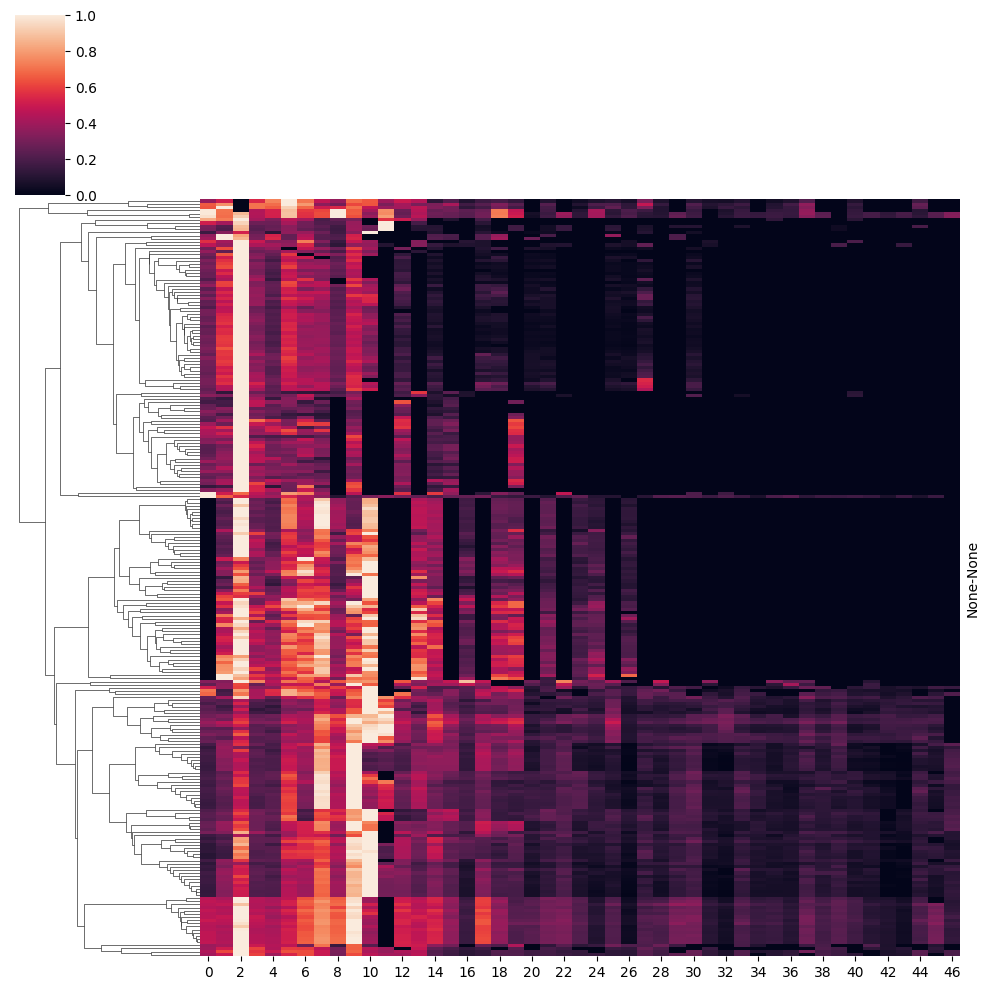

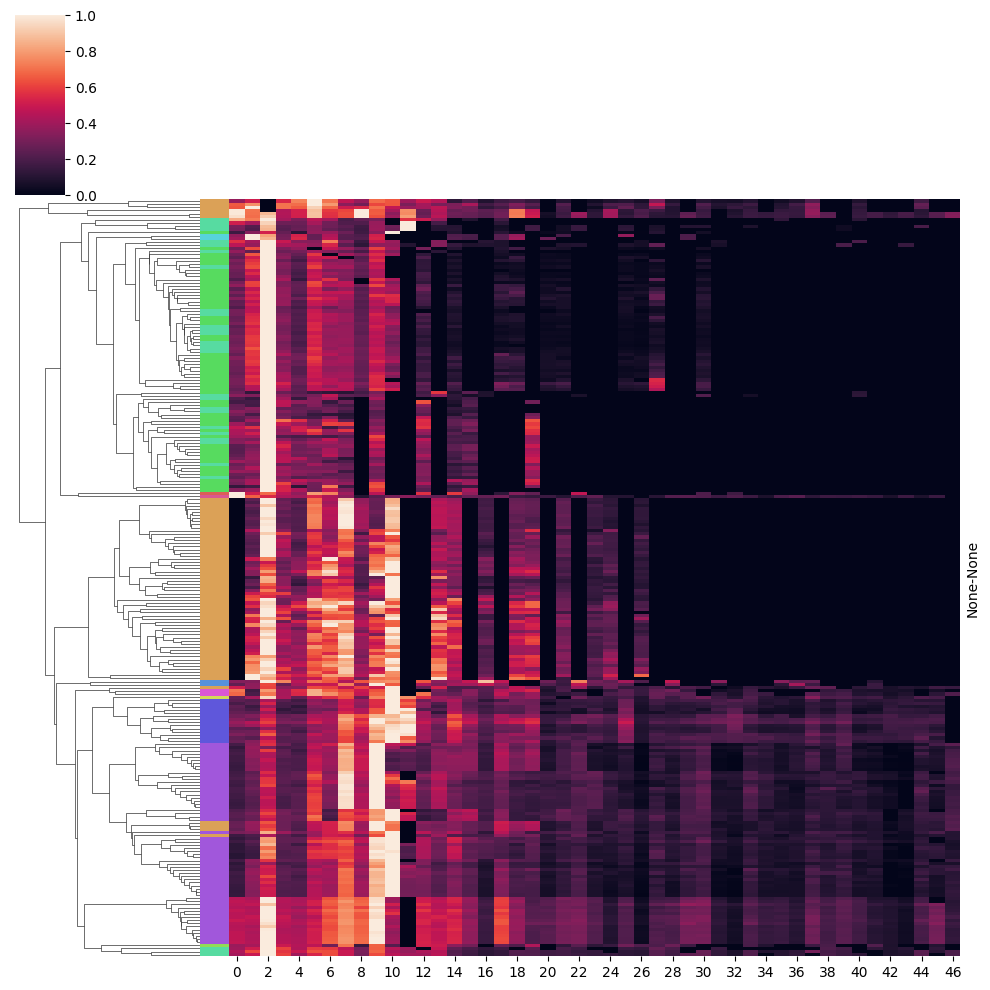

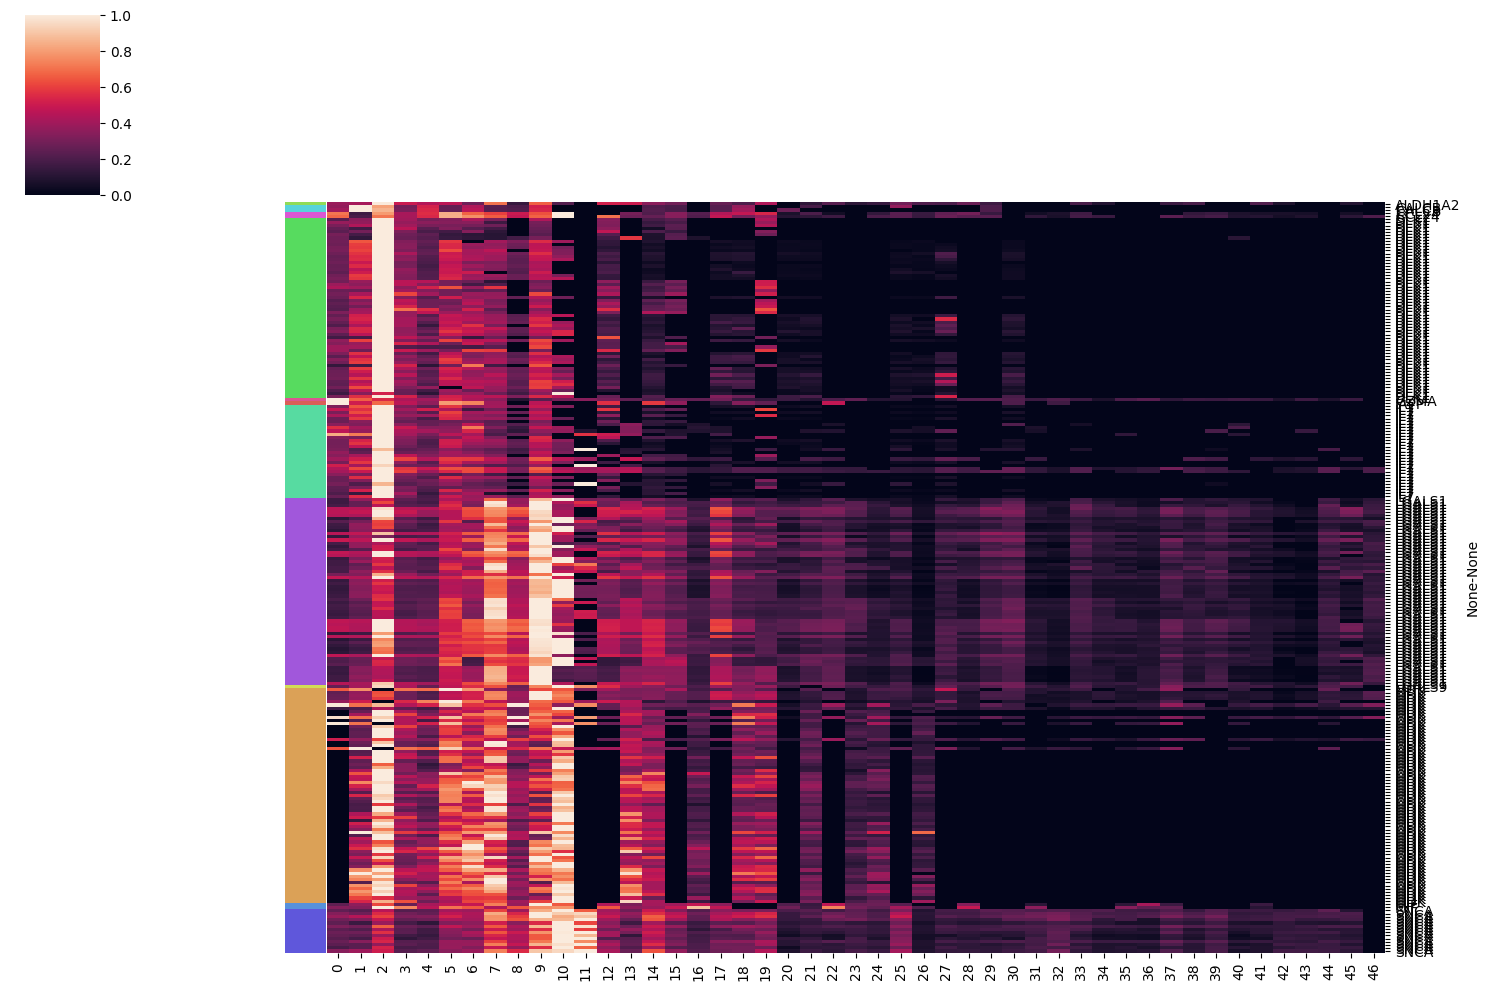

In [5]:
# Load pre-calculated data if overwrite flag is False
sig_int_decreasing = pkl_load(f'{directory}rec_lig_outs/sig_int_dec_means')
values_decreasing = pkl_load(f'{directory}rec_lig_outs/sig_int_dec_values')
sig_int_increasing = pkl_load(f'{directory}rec_lig_outs/sig_int_inc_means')
values_increasing = pkl_load(f'{directory}rec_lig_outs/sig_int_inc_values')
sig_int = pkl_load(f'{directory}rec_lig_outs/sig_int_means')
values = pkl_load(f'{directory}rec_lig_outs/sig_int_values')


# Select interactions and values based on the specified plot type
if plot_type == 'decreasing':
    value_use, index_use = copy.deepcopy(values_decreasing), copy.deepcopy(sig_int_decreasing)
elif plot_type == 'increasing':
    value_use, index_use = copy.deepcopy(values_increasing), copy.deepcopy(sig_int_increasing)
elif plot_type == 'both':
    value_use, index_use = copy.deepcopy(values), copy.deepcopy(sig_int)

# Ensure all values have the correct length (47 time points)
value_use, index_use = zip(*[(v, i) for v, i in zip(value_use, index_use) if len(v) == 47])

# Create a DataFrame for visualization
plot_pd = pd.DataFrame(np.array(value_use), index=index_use)

# Generate hierarchical clustering heatmap
grid = sns.clustermap(plot_pd, col_cluster=False, yticklabels=False, standard_scale=0)

# Reorder rows based on clustering results
reordered_indices = grid.dendrogram_row.reordered_ind
sig_int_reorder = [index_use[i] for i in reordered_indices]

# Assign colors to interaction categories
row_labels = [i[0][0] for i in sig_int_reorder]
colors = sns.color_palette("hls", len(set(row_labels)))
row_labels_to_color = {label: color for label, color in zip(set(row_labels), colors)}
row_colors = [row_labels_to_color[i] for i in row_labels]

# Generate another clustermap with assigned row colors
orig_order_labels = [i[0][0] for i in plot_pd.index]
orig_order_colors = [row_labels_to_color[i] for i in orig_order_labels]
grid = sns.clustermap(plot_pd, col_cluster=False, yticklabels=False,
                      row_colors=orig_order_colors, standard_scale=0)

# Extract and sort ligand names
ligands = [i[0][0] for i in plot_pd.index]
plot_pd['lig'] = ligands
plot_pd = plot_pd.sort_values('lig')
ligands_sorted = plot_pd['lig']
orig_order_colors = [row_labels_to_color[i] for i in ligands_sorted]
plot_pd = plot_pd.drop(columns=['lig'])

# Final visualization with sorted ligand names
grid = sns.clustermap(plot_pd, yticklabels=ligands_sorted, row_cluster=False,
                      col_cluster=False, row_colors=orig_order_colors,
                      figsize=(15,10), standard_scale=0)

In [6]:
# Set flag to determine whether to run significance analysis
run_sig_int = False

overwrite = False # Flag to determine whether to overwrite saved data


if run_sig_int:
    # Initialize lists for storing significant interactions and values
    sig_int = []  # Stores significant interactions
    values = []  # Stores corresponding values
    show_plots = True  # Flag for showing plots
    corr_agg = []  # Stores correlation coefficients
    skip_cter = 0  # Counter for skipped interactions
    pval_all = []  # Stores p-values
    metric = agg_output  # Source data for analysis
    
    # Separate lists for increasing and decreasing correlations
    sig_int_decreasing, values_decreasing = [], []
    sig_int_increasing, values_increasing = [], []
    
    show_plot_cter = 0  # Counter for plots
    
    # Iterate over interactions and perform significance testing
    for interac in tqdm(metric):
        # Skip interactions with integer identifiers or specific header labels
        if isinstance(interac[0], int) or interac[0] in [('source', 'target')]:
            continue
        if interac[1] in [('cluster_1', 'cluster_2'), ('Unnamed: 1_level_0', 'Unnamed: 1_level_1')]:
            continue
        
        # Extract x (age-transformed batch indices) and y (metric values)
        x_filt, y_filt = zip(*metric[interac])
        x_filt = [batch_to_age[i] for i in x_filt]
        x_filt = [np.log10(i + 1) for i in x_filt]
        
        # Compute Spearman correlation and p-value
        corr, pval = scipy.stats.spearmanr(x_filt, y_filt)
        corr_agg.append(corr)
        pval_all.append(pval)
        
        # Apply Bonferroni correction for significance threshold
        if pval < 0.05 / len(agg_output_pval):
            if corr < 0:
                sig_int_decreasing.append(interac)
                values_decreasing.append(list(y_filt))
            elif corr > 0:
                sig_int_increasing.append(interac)
                values_increasing.append(list(y_filt))
            sig_int.append(interac)
            values.append(list(y_filt))
else:
    # Load pre-calculated significant interactions if flag is False
    sig_int = pkl_load(f'{directory}rec_lig_outs/sig_int_means')
    values = pkl_load(f'{directory}rec_lig_outs/sig_int_values')

if overwrite:
    # Save computed data to disk if overwrite flag is True
    with open(f'{directory}rec_lig_outs/sig_int_means.pkl', 'wb') as f:
        pk.dump(sig_int, f)
    with open(f'{directory}rec_lig_outs/sig_int_values.pkl', 'wb') as f:
        pk.dump(values, f)
    with open(f'{directory}rec_lig_outs/sig_int_inc_means.pkl', 'wb') as f:
        pk.dump(sig_int_increasing, f)
    with open(f'{directory}rec_lig_outs/sig_int_inc_values.pkl', 'wb') as f:
        pk.dump(values_increasing, f)
    with open(f'{directory}rec_lig_outs/sig_int_dec_means.pkl', 'wb') as f:
        pk.dump(sig_int_increasing, f)
    with open(f'{directory}rec_lig_outs/sig_int_dec_values.pkl', 'wb') as f:
        pk.dump(values_increasing, f)
else:
    # Load pre-calculated data if overwrite flag is False
    sig_int_decreasing = pkl_load(f'{directory}rec_lig_outs/sig_int_dec_means')
    values_decreasing = pkl_load(f'{directory}rec_lig_outs/sig_int_dec_values')
    sig_int_increasing = pkl_load(f'{directory}rec_lig_outs/sig_int_inc_means')
    values_increasing = pkl_load(f'{directory}rec_lig_outs/sig_int_dec_values')
    sig_int = pkl_load(f'{directory}rec_lig_outs/sig_int_means')
    values = pkl_load(f'{directory}rec_lig_outs/sig_int_values')

# Select interactions and values based on the specified plot type
if plot_type == 'decreasing':
    value_use, index_use = copy.deepcopy(values_decreasing), copy.deepcopy(sig_int_decreasing)
elif plot_type == 'increasing':
    value_use, index_use = copy.deepcopy(values_increasing), copy.deepcopy(sig_int_increasing)
elif plot_type == 'both':
    value_use, index_use = copy.deepcopy(values), copy.deepcopy(sig_int)

# Ensure all values have the correct length (47 time points)
value_use, index_use = zip(*[(v, i) for v, i in zip(value_use, index_use) if len(v) == 47])

# Create a DataFrame for visualization
plot_pd = pd.DataFrame(np.array(value_use), index=index_use)


Decile 1: [0, 0, 1, 1, 2, 2, 2]
Decile 2: [3, 3, 3, 4, 4, 5, 5, 7, 7]
Decile 3: [10, 10, 13, 13, 21, 21, 28, 28]
Decile 4: [35, 35, 35, 49, 49, 63, 63]
Decile 5: [91, 91, 105, 105, 196, 196]
Decile 6: [224, 224, 224, 336, 336, 476, 476, 476, 630, 630]


/var/folders/sl/jxm7y4r50vx7spm79kb8_v4r0000gp/T/ipykernel_88739/3256090811.py:41: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_decile = df_decile.groupby(level=0, axis=1).mean()


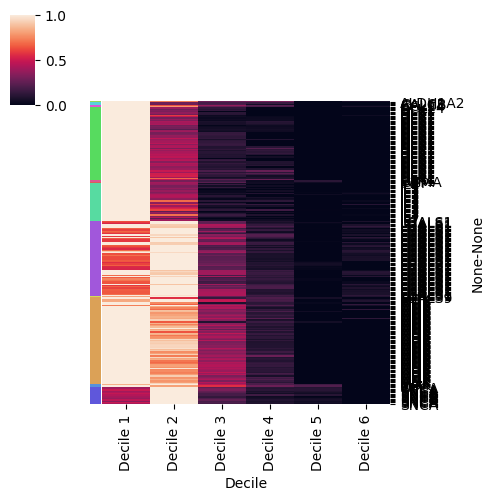

In [7]:
# Transpose the DataFrame to have time points as index
df = pd.DataFrame.transpose(plot_pd)

# Number of bins for time point categorization
num_bins = 6

# Convert batch identifiers to actual time points using a mapping dictionary
time_points = list(df.index)
time_points = [batch_to_tpt[i] for i in time_points]
df.index = time_points  # Update the index with time points

# Create a dictionary that maps time points into bins (deciles)
deciles_dict = create_bins_dict(time_points, num_bins)

# Manually add specific time points to certain deciles
deciles_dict['Decile 5'] = [91, 91, 105, 105, 196, 196]
deciles_dict['Decile 6'] = [224, 224, 224, 336, 336, 476, 476, 476, 630, 630]

# Create a mapping from time points to their respective deciles
time_to_decile_dict = {}

# Print decile groupings and populate the mapping dictionary
for key, values in deciles_dict.items():
    print(f'{key}: {values}')
    for val in values:
        time_to_decile_dict[val] = key  # Assign each time point to its corresponding decile

# Create a copy of the original DataFrame for decile-based grouping
df_decile = copy.deepcopy(df)

# Assign each time point its corresponding decile label
df_decile['Decile'] = [time_to_decile_dict[i] for i in df_decile.index]

# Set decile labels as the index
df_decile = df_decile.set_index('Decile')

# Transpose the DataFrame so deciles are in columns
df_decile = pd.DataFrame.transpose(df_decile)

# Compute mean values for each decile
df_decile = df_decile.groupby(level=0, axis=1).mean()

# Extract ligand names from the index
ligands = [i[0][0] for i in df_decile.index]

# Add ligand names as a new column for sorting purposes
df_decile['lig'] = ligands

# Sort the DataFrame by ligand names
df_decile = df_decile.sort_values('lig')

# Extract the sorted ligand names
ligands_sorted = df_decile['lig']

# Assign colors based on ligand categories
orig_order_colors = [row_labels_to_color[i] for i in ligands_sorted]

# Drop the ligand column after sorting
df_decile = df_decile.drop(columns=['lig'])

# Create a clustered heatmap without row clustering
grid = sns.clustermap(df_decile, yticklabels=ligands_sorted,
                      row_cluster=False, col_cluster=False,
                      row_colors=orig_order_colors,
                      figsize=(5,5), standard_scale=0)

# Save the clustered heatmap based on the plot type
if plot_type == 'decreasing':
    grid.savefig(f'{output_directory}S5A_reclig_dec_grouped.pdf')
elif plot_type == 'increasing':
    grid.savefig(f'{output_directory}S5A_reclig_inc_grouped.pdf')

## S5B

In [8]:
# Specify type of interaction to plot
plot_type = 'increasing'  # Options: 'decreasing' (Figure 3B), 'increasing' (Figure S5B), 'both'

In [9]:
adata = copy.deepcopy(adata_combined)

batch_to_age = {j:i for i,j in zip(adata.obs.Age,adata.obs.Batch)}

In [10]:
# Set re_run_calc and save flags
re_run_calc = False
save = False

# Re-run calculations if re_run_calc flag is True
if re_run_calc:
    # Loop over batches in the dataset
    for batch in tqdm(set(adata.obs.Batch)):
        # Skip if output files already exist
        if os.path.exists(f'{directory}rec_lig_outs/{batch}_means.csv'):
            continue
        
        # Filter the data by batch
        adata_filt = adata[adata.obs.Batch == batch]
        
        # Set spatial coordinates
        adata_filt.obsm['spatial'] = np.array([(float(i), float(j)) for i, j in zip(adata_filt.obs['x_val'], adata_filt.obs['y_val'])])
        
        # Calculate spatial neighbors
        sq.gr.spatial_neighbors(adata_filt, coord_type='generic')
        
        # Calculate neighborhood enrichment
        sq.gr.nhood_enrichment(adata_filt, cluster_key="Cell_type")

        # Perform ligrec analysis
        res = sq.gr.ligrec(
            adata_filt,
            n_perms=1000,
            cluster_key="Cell_type",
            copy=True,
            use_raw=False,
            transmitter_params={"categories": "ligand"},
            receiver_params={"categories": "receptor"},
            n_jobs = 10
        )

        # Save means and p-values to CSV files
        means = res["means"]
        pvals = res["pvalues"]
        means.to_csv(f'{directory}rec_lig_outs/{batch}_means.csv')
        pvals.to_csv(f'{directory}rec_lig_outs/{batch}_pvals.csv')

    # Aggregate means and p-values from CSV files
    agg_output = {}
    agg_output_pval = {}
    for batch in tqdm(set(adata.obs.Batch)):
        means = pd.read_csv(f'{directory}rec_lig_outs/{batch}_means.csv', header=[0, 1])
        pvals = pd.read_csv(f'{directory}rec_lig_outs/{batch}_pvals.csv', header=[0, 1])

        col_names = means.columns
        for index, row in means.iterrows():
            rec_lig = (
                row[("cluster_1", "cluster_2")],
                row[("Unnamed: 1_level_0", "Unnamed: 1_level_1")],
            )
            for idx in range(len(row)):
                val = row[idx]
                col = col_names[idx]
                if (rec_lig, col) not in agg_output:
                    agg_output[(rec_lig, col)] = []
                agg_output[(rec_lig, col)].append((batch, val))

        col_names = pvals.columns
        for index, row in pvals.iterrows():
            rec_lig = (
                row[("cluster_1", "cluster_2")],
                row[("Unnamed: 1_level_0", "Unnamed: 1_level_1")],
            )
            for idx in range(len(row)):
                val = row[idx]
                if type(val) == str:
                    continue
                if np.max(val) > 1:
                    print(val, batch)
                    break
                col = col_names[idx]
                if (rec_lig, col) not in agg_output_pval:
                    agg_output_pval[(rec_lig, col)] = []
                agg_output_pval[(rec_lig, col)].append((batch, val))

    # Save aggregated data if the save flag is True
    if save:
        with open(f'{directory}/rec_lig_outs/means_ligrec.pkl', 'wb') as output_file:
            pk.dump(agg_output, output_file)

        with open(f'{directory}/rec_lig_outs/pval_ligrec.pkl', 'wb') as output_file:
            pk.dump(agg_output_pval, output_file)

# Load pre-calculated data if re_run_calc is False
else:
    agg_output_pval = pkl_load(f'{directory}/rec_lig_outs/pval_ligrec')
    agg_output = pkl_load(f'{directory}/rec_lig_outs/means_ligrec')

/Users/sx931/miniconda3/envs/aging_thymus/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


KeyboardInterrupt: 

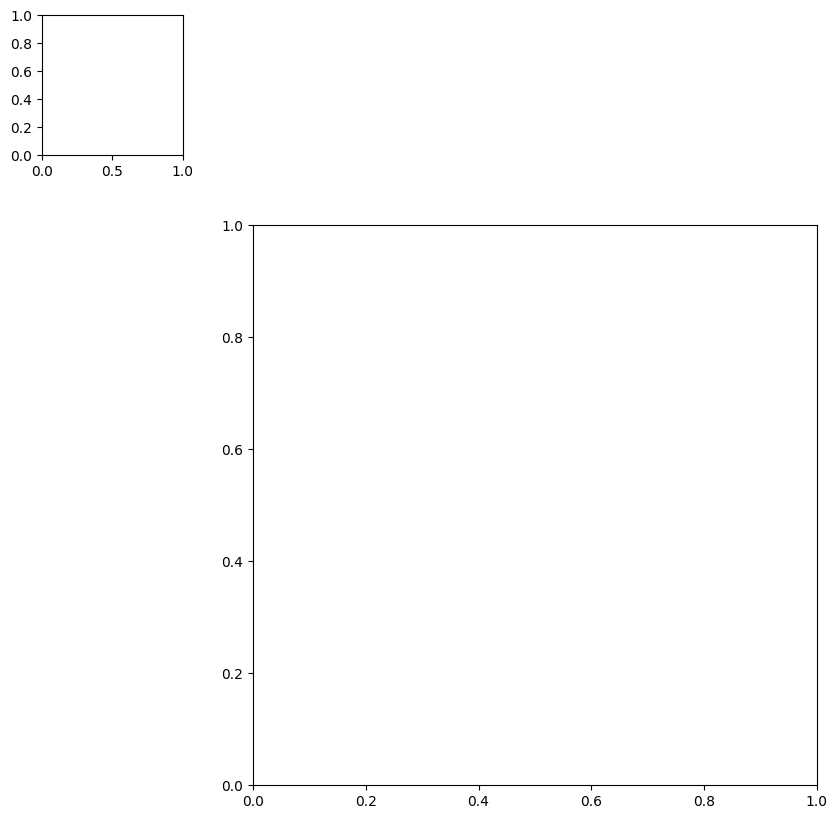

In [11]:
# Set flag to determine whether to run significance analysis
run_sig_int = False

overwrite = False # Flag to determine whether to overwrite saved data

if run_sig_int:
    # Initialize lists for storing significant interactions and values
    sig_int = []  # Stores significant interactions
    values = []  # Stores corresponding values
    show_plots = True  # Flag for showing plots
    corr_agg = []  # Stores correlation coefficients
    skip_cter = 0  # Counter for skipped interactions
    pval_all = []  # Stores p-values
    metric = agg_output  # Source data for analysis
    
    # Separate lists for increasing and decreasing correlations
    sig_int_decreasing, values_decreasing = [], []
    sig_int_increasing, values_increasing = [], []
    
    show_plot_cter = 0  # Counter for plots
    
    # Iterate over interactions and perform significance testing
    for interac in tqdm(metric):
        # Skip interactions with integer identifiers or specific header labels
        if isinstance(interac[0], int) or interac[0] in [('source', 'target')]:
            continue
        if interac[1] in [('cluster_1', 'cluster_2'), ('Unnamed: 1_level_0', 'Unnamed: 1_level_1')]:
            continue
        
        # Extract x (age-transformed batch indices) and y (metric values)
        x_filt, y_filt = zip(*metric[interac])
        x_filt = [batch_to_age[i] for i in x_filt]
        x_filt = [np.log10(i + 1) for i in x_filt]
        
        # Compute Spearman correlation and p-value
        corr, pval = scipy.stats.spearmanr(x_filt, y_filt)
        corr_agg.append(corr)
        pval_all.append(pval)
        
        # Apply Bonferroni correction for significance threshold
        if pval < 0.05 / len(agg_output_pval):
            if corr < 0:
                sig_int_decreasing.append(interac)
                values_decreasing.append(list(y_filt))
            elif corr > 0:
                sig_int_increasing.append(interac)
                values_increasing.append(list(y_filt))
            sig_int.append(interac)
            values.append(list(y_filt))
else:
    # Load pre-calculated significant interactions if flag is False
    sig_int = pkl_load(f'{directory}rec_lig_outs/sig_int_means')
    values = pkl_load(f'{directory}rec_lig_outs/sig_int_values')

if overwrite:
    # Save computed data to disk if overwrite flag is True
    with open(f'{directory}rec_lig_outs/sig_int_means.pkl', 'wb') as f:
        pk.dump(sig_int, f)
    with open(f'{directory}rec_lig_outs/sig_int_values.pkl', 'wb') as f:
        pk.dump(values, f)
    with open(f'{directory}rec_lig_outs/sig_int_inc_means.pkl', 'wb') as f:
        pk.dump(sig_int_increasing, f)
    with open(f'{directory}rec_lig_outs/sig_int_inc_values.pkl', 'wb') as f:
        pk.dump(values_increasing, f)
    with open(f'{directory}rec_lig_outs/sig_int_dec_means.pkl', 'wb') as f:
        pk.dump(sig_int_decreasing, f)
    with open(f'{directory}rec_lig_outs/sig_int_dec_values.pkl', 'wb') as f:
        pk.dump(values_decreasing, f)
else:
    # Load pre-calculated data if overwrite flag is False
    sig_int_decreasing = pkl_load(f'{directory}rec_lig_outs/sig_int_dec_means')
    values_decreasing = pkl_load(f'{directory}rec_lig_outs/sig_int_dec_values')
    sig_int_increasing = pkl_load(f'{directory}rec_lig_outs/sig_int_inc_means')
    values_increasing = pkl_load(f'{directory}rec_lig_outs/sig_int_inc_values')
    sig_int = pkl_load(f'{directory}rec_lig_outs/sig_int_means')
    values = pkl_load(f'{directory}rec_lig_outs/sig_int_values')


# Select interactions and values based on the specified plot type
if plot_type == 'decreasing':
    value_use, index_use = copy.deepcopy(values_decreasing), copy.deepcopy(sig_int_decreasing)
elif plot_type == 'increasing':
    value_use, index_use = copy.deepcopy(values_increasing), copy.deepcopy(sig_int_increasing)
elif plot_type == 'both':
    value_use, index_use = copy.deepcopy(values), copy.deepcopy(sig_int)

# Ensure all values have the correct length (47 time points)
value_use, index_use = zip(*[(v, i) for v, i in zip(value_use, index_use) if len(v) == 47])

# Create a DataFrame for visualization
plot_pd = pd.DataFrame(np.array(value_use), index=index_use)

# Generate hierarchical clustering heatmap
grid = sns.clustermap(plot_pd, col_cluster=False, yticklabels=False, standard_scale=0)

# Reorder rows based on clustering results
reordered_indices = grid.dendrogram_row.reordered_ind
sig_int_reorder = [index_use[i] for i in reordered_indices]

# Assign colors to interaction categories
row_labels = [i[0][0] for i in sig_int_reorder]
colors = sns.color_palette("hls", len(set(row_labels)))
row_labels_to_color = {label: color for label, color in zip(set(row_labels), colors)}
row_colors = [row_labels_to_color[i] for i in row_labels]

# Generate another clustermap with assigned row colors
orig_order_labels = [i[0][0] for i in plot_pd.index]
orig_order_colors = [row_labels_to_color[i] for i in orig_order_labels]
grid = sns.clustermap(plot_pd, col_cluster=False, yticklabels=False,
                      row_colors=orig_order_colors, standard_scale=0)
grid.savefig('reclig.pdf')

# Extract and sort ligand names
ligands = [i[0][0] for i in plot_pd.index]
plot_pd['lig'] = ligands
plot_pd = plot_pd.sort_values('lig')
ligands_sorted = plot_pd['lig']
orig_order_colors = [row_labels_to_color[i] for i in ligands_sorted]
plot_pd = plot_pd.drop(columns=['lig'])

# Final visualization with sorted ligand names
grid = sns.clustermap(plot_pd, yticklabels=ligands_sorted, row_cluster=False,
                      col_cluster=False, row_colors=orig_order_colors,
                      figsize=(15,10), standard_scale=0)

# Save plot according to interaction type
if plot_type == 'decreasing':
    grid.savefig(f'{output_directory}S5B_reclig_dec.pdf')
elif plot_type == 'increasing':
    grid.savefig(f'{output_directory}S5B_reclig_inc.pdf')

## S5C

In [ ]:
plot_type = 'increasing'

In [ ]:
# Set flag to determine whether to run significance analysis
run_sig_int = False

overwrite = False # Flag to determine whether to overwrite saved data

if run_sig_int:
    # Initialize lists for storing significant interactions and values
    sig_int = []  # Stores significant interactions
    values = []  # Stores corresponding values
    show_plots = True  # Flag for showing plots
    corr_agg = []  # Stores correlation coefficients
    skip_cter = 0  # Counter for skipped interactions
    pval_all = []  # Stores p-values
    metric = agg_output  # Source data for analysis
    
    # Separate lists for increasing and decreasing correlations
    sig_int_decreasing, values_decreasing = [], []
    sig_int_increasing, values_increasing = [], []
    
    show_plot_cter = 0  # Counter for plots
    
    # Iterate over interactions and perform significance testing
    for interac in tqdm(metric):
        # Skip interactions with integer identifiers or specific header labels
        if isinstance(interac[0], int) or interac[0] in [('source', 'target')]:
            continue
        if interac[1] in [('cluster_1', 'cluster_2'), ('Unnamed: 1_level_0', 'Unnamed: 1_level_1')]:
            continue
        
        # Extract x (age-transformed batch indices) and y (metric values)
        x_filt, y_filt = zip(*metric[interac])
        x_filt = [batch_to_age[i] for i in x_filt]
        x_filt = [np.log10(i + 1) for i in x_filt]
        
        # Compute Spearman correlation and p-value
        corr, pval = scipy.stats.spearmanr(x_filt, y_filt)
        corr_agg.append(corr)
        pval_all.append(pval)
        
        # Apply Bonferroni correction for significance threshold
        if pval < 0.05 / len(agg_output_pval):
            if corr < 0:
                sig_int_decreasing.append(interac)
                values_decreasing.append(list(y_filt))
            elif corr > 0:
                sig_int_increasing.append(interac)
                values_increasing.append(list(y_filt))
            sig_int.append(interac)
            values.append(list(y_filt))
else:
    # Load pre-calculated significant interactions if flag is False
    sig_int = pkl_load(f'{directory}rec_lig_outs/sig_int_means')
    values = pkl_load(f'{directory}rec_lig_outs/sig_int_values')

if overwrite:
    # Save computed data to disk if overwrite flag is True
    with open(f'{directory}rec_lig_outs/sig_int_means.pkl', 'wb') as f:
        pk.dump(sig_int, f)
    with open(f'{directory}rec_lig_outs/sig_int_values.pkl', 'wb') as f:
        pk.dump(values, f)
    with open(f'{directory}rec_lig_outs/sig_int_inc_means.pkl', 'wb') as f:
        pk.dump(sig_int_increasing, f)
    with open(f'{directory}rec_lig_outs/sig_int_inc_values.pkl', 'wb') as f:
        pk.dump(values_increasing, f)
    with open(f'{directory}rec_lig_outs/sig_int_dec_means.pkl', 'wb') as f:
        pk.dump(sig_int_decreasing, f)
    with open(f'{directory}rec_lig_outs/sig_int_dec_values.pkl', 'wb') as f:
        pk.dump(values_decreasing, f)
else:
    # Load pre-calculated data if overwrite flag is False
    sig_int_decreasing = pkl_load(f'{directory}rec_lig_outs/sig_int_dec_means')
    values_decreasing = pkl_load(f'{directory}rec_lig_outs/sig_int_dec_values')
    sig_int_increasing = pkl_load(f'{directory}rec_lig_outs/sig_int_inc_means')
    values_increasing = pkl_load(f'{directory}rec_lig_outs/sig_int_inc_values')
    sig_int = pkl_load(f'{directory}rec_lig_outs/sig_int_means')
    values = pkl_load(f'{directory}rec_lig_outs/sig_int_values')

# Select interactions and values based on the specified plot type
if plot_type == 'decreasing':
    value_use, index_use = copy.deepcopy(values_decreasing), copy.deepcopy(sig_int_decreasing)
elif plot_type == 'increasing':
    value_use, index_use = copy.deepcopy(values_increasing), copy.deepcopy(sig_int_increasing)
elif plot_type == 'both':
    value_use, index_use = copy.deepcopy(values), copy.deepcopy(sig_int)

# Ensure all values have the correct length (47 time points)
value_use, index_use = zip(*[(v, i) for v, i in zip(value_use, index_use) if len(v) == 47])

# Create a DataFrame for visualization
plot_pd = pd.DataFrame(np.array(value_use), index=index_use)


In [ ]:
# Transpose the DataFrame to have time points as index
df = pd.DataFrame.transpose(plot_pd)

# Number of bins for time point categorization
num_bins = 6

# Convert batch identifiers to actual time points using a mapping dictionary
time_points = list(df.index)
time_points = [batch_to_tpt[i] for i in time_points]
df.index = time_points  # Update the index with time points

# Create a dictionary that maps time points into bins (deciles)
deciles_dict = create_bins_dict(time_points, num_bins)

# Manually add specific time points to certain deciles
deciles_dict['Decile 5'] = [91, 91, 105, 105, 196, 196]
deciles_dict['Decile 6'] = [224, 224, 224, 336, 336, 476, 476, 476, 630, 630]

# Create a mapping from time points to their respective deciles
time_to_decile_dict = {}

# Print decile groupings and populate the mapping dictionary
for key, values in deciles_dict.items():
    print(f'{key}: {values}')
    for val in values:
        time_to_decile_dict[val] = key  # Assign each time point to its corresponding decile

# Create a copy of the original DataFrame for decile-based grouping
df_decile = copy.deepcopy(df)

# Assign each time point its corresponding decile label
df_decile['Decile'] = [time_to_decile_dict[i] for i in df_decile.index]

# Set decile labels as the index
df_decile = df_decile.set_index('Decile')

# Transpose the DataFrame so deciles are in columns
df_decile = pd.DataFrame.transpose(df_decile)

# Compute mean values for each decile
df_decile = df_decile.groupby(level=0, axis=1).mean()

# Extract ligand names from the index
ligands = [i[0][0] for i in df_decile.index]

# Add ligand names as a new column for sorting purposes
df_decile['lig'] = ligands

# Sort the DataFrame by ligand names
df_decile = df_decile.sort_values('lig')

# Extract the sorted ligand names
ligands_sorted = df_decile['lig']

# Assign colors based on ligand categories
orig_order_colors = [row_labels_to_color[i] for i in ligands_sorted]

# Drop the ligand column after sorting
df_decile = df_decile.drop(columns=['lig'])

# Create a clustered heatmap without row clustering
grid = sns.clustermap(df_decile, yticklabels=ligands_sorted,
                      row_cluster=False, col_cluster=False,
                      row_colors=orig_order_colors,
                      figsize=(5,5), standard_scale=0)

# Save the clustered heatmap based on the plot type
if plot_type == 'decreasing':
    grid.savefig(f'{output_directory}S5C_reclig_dec_grouped.pdf')
elif plot_type == 'increasing':
    grid.savefig(f'{output_directory}S5C_reclig_inc_grouped.pdf')